# Genetic Algorithm for Course Scheduling

This notebook implements a **Genetic Algorithm (GA)** that automatically builds a class schedule with minimal conflicts.

### Objectives
- Avoid teacher and student time conflicts  
- Use classrooms efficiently  
- Minimize consecutive teaching days  
- Reward compact schedules and free days  

Each cell below focuses on one part of the algorithm and everything is modular and easy to follow.

## Importing Required Libraries

These are the Python libraries needed for:
- Data handling (`pandas`, `pathlib`)
- Random operations and regex (`random`, `re`)
- Plotting (`matplotlib`)
- Parallel processing (`multiprocessing`)
- File system and utility functions

In [1]:
import random
import re
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import multiprocessing
from functools import partial
import time

## Configuration and GA Parameters

This cell defines:
- Input and output file paths  
- Days, time slots, and available rooms  
- GA hyperparameters (population size, mutation rate, etc.)  
- Penalty and reward weights used in the fitness function  
- Dataset generation setup for students and courses

In [2]:
# ---------------- CONFIG ----------------
DATA_FILE = Path(r"D:\UNI AI\Unit Selecetion\report.txt")
COURSES_DATA_FILE = Path(r"D:\UNI AI\Unit Selecetion\courses_data.xlsx")
STUDENTS_DATA_FILE = Path(r"D:\UNI AI\Unit Selecetion\students_data.xlsx")
OUTPUT_FILE = Path(r"D:\UNI AI\Unit Selecetion\schedule_output.csv")

DAYS = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday"]
TIME_SLOTS = ["8-10", "10-12", "13.5-15.5", "15.5-17.5", "17.5-19.5"]
ROOMS = [
    {"name": "Room 101", "capacity": 20},
    {"name": "Room 102", "capacity": 30},
    {"name": "Room 103", "capacity": 40},
    {"name": "Room 104", "capacity": 50},
    {"name": "Room 105", "capacity": 60},
]

# Genetic Algorithm parameters
POP_SIZE = 200
GENERATIONS = 800
TOURNAMENT_K = 3
CROSSOVER_RATE = 0.85
MUTATION_RATE = 0.20
ELITISM_RATE = 0.05
RANDOM_SEED = 42

# Penalty / Reward values
PENALTY_TEACHER_CONFLICT = 10
PENALTY_STUDENT_CONFLICT = 5
PENALTY_OVER_CAPACITY = 5
PENALTY_UNDER_UTIL_THRESH = 0.5
PENALTY_UNDER_UTIL = 1
REWARD_DAY_OFF = 2
PENALTY_GAP = 1
PENALTY_CONSECUTIVE_DAY = 1000
PENALTY_SAME_DAY = 100
PENALTY_SAME_DAY_QUAD = True

# Dataset generation
NUM_STUDENTS = 100
MIN_COURSES_PER_STUDENT = 3
MAX_COURSES_PER_STUDENT = 5

random.seed(RANDOM_SEED)

## Helper Function — Clean Teacher Field

This function normalizes the teacher field extracted from the report file.  
It:
- Splits by HTML `<BR>` tags, commas, or semicolons  
- Removes whitespace  
- Returns a list of teacher names (or `["Unknown"]` if empty)

In [3]:
def clean_teacher_field(raw):
    if not raw:
        return ["Unknown"]
    parts = [p.strip() for p in re.split(r"<BR>|<br>|;|,", raw) if p.strip()]
    return parts or ["Unknown"]

## Function — Parse Report File

This function reads the raw university report text file and extracts:
- Course names  
- Teacher names  
- Number of registered students  

Each record is returned as a dictionary with `course`, `teachers`, and `registered` keys.

In [4]:
def parse_report(file_path):
    if not file_path.exists():
        print(f"ERROR: data file '{file_path}' not found.", file=sys.stderr)
        return []
    recs = []
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        header = next(f, "")
        for line in f:
            cols = line.rstrip("\n").split("\t")
            if len(cols) < 6:
                continue
            course = cols[5].strip() if len(cols) > 5 else "UnknownCourse"
            teacher_raw = cols[12] if len(cols) > 12 else ""
            reg_raw = cols[9] if len(cols) > 9 else "0"
            try:
                reg = int(re.sub(r"[^\d]", "", reg_raw)) if re.search(r"\d", reg_raw) else 0
            except:
                reg = 0
            teachers = clean_teacher_field(teacher_raw)
            if reg <= 0:
                reg = 5
            recs.append({"course": course, "teachers": teachers, "registered": reg})
    print(f"[DATA] Parsed {len(recs)} courses from {file_path}")
    return recs

## Function — Build Datasets

This function constructs:
- A dictionary of courses with their teachers, enrolled students, and preferred rooms  
- A dictionary of students and their registered courses  

It also exports both datasets to Excel for easier inspection.

In [5]:
def build_datasets(records):
    courses_dict = {}
    teachers_set = set()

    for r in records:
        course = r["course"]
        teacher = r["teachers"][0] if r["teachers"] else "Unknown"
        teachers_set.add(teacher)
        courses_dict[course] = {
            "teacher": teacher,
            "registered": r["registered"],
            "students": [],
            "preferred_rooms": [rm["name"] for rm in sorted(ROOMS, key=lambda x: x["capacity"]) if rm["capacity"] >= r["registered"]]
        }

    student_dict = {}
    course_list = list(courses_dict.keys())

    for i in range(1, NUM_STUDENTS + 1):
        sname = f"Student_{i}"
        num_courses = random.randint(MIN_COURSES_PER_STUDENT, MAX_COURSES_PER_STUDENT)
        chosen_courses = random.sample(course_list, min(num_courses, len(course_list)))
        student_dict[sname] = chosen_courses
        for c in chosen_courses:
            courses_dict[c]["students"].append(sname)

    print(f"[DATA] Built {len(courses_dict)} courses, {len(teachers_set)} teachers, {len(student_dict)} students")

    df_courses = pd.DataFrame([
        {"course": c, "teacher": v["teacher"], "registered": len(v["students"]), "students": ", ".join(v["students"])}
        for c, v in courses_dict.items()
    ])
    df_students = pd.DataFrame([
        {"student": s, "courses": ", ".join(c_list)}
        for s, c_list in student_dict.items()
    ])
    COURSES_DATA_FILE.parent.mkdir(parents=True, exist_ok=True)
    df_courses.to_excel(COURSES_DATA_FILE, index=False)
    df_students.to_excel(STUDENTS_DATA_FILE, index=False)
    print(f"[DATA] Saved courses data to {COURSES_DATA_FILE}")
    print(f"[DATA] Saved students data to {STUDENTS_DATA_FILE}")

    return courses_dict, teachers_set, student_dict

## Helper Function — Default Room Capacity

Returns the capacity of the largest available room.
Used when a course doesn’t have any matching preferred rooms.

In [6]:
def ROOM_CAPACITY_DEFAULT():
    return max(r["capacity"] for r in ROOMS)

## Helper Function — Random Slot Generator

Generates a random `(day, time, room)` tuple.
Used for initializing random schedules.

In [7]:
def random_slot():
    return (
        random.randrange(len(DAYS)),
        random.randrange(len(TIME_SLOTS)),
        random.choice([r["name"] for r in ROOMS])
    )

## Function — Greedy Initialization

This function creates the initial population for the GA.

### How it works
1. Each course is assigned a random (day, time, room) slot.
2. It tries to **avoid teacher conflicts** by skipping slots already taken by that teacher.
3. Returns a list of individuals (each is a dictionary mapping course → slot).

In [8]:
def greedy_initialization(courses_dict, pop_size=POP_SIZE):
    population = []

    for _ in range(pop_size):
        teacher_schedule = defaultdict(set)
        individual = {}

        for course, info in courses_dict.items():
            teacher = info["teacher"]
            assigned = False
            attempts = 0

            while not assigned and attempts < 20:
                day, time, room = random_slot()
                if (day, time) not in teacher_schedule[teacher]:
                    individual[course] = (day, time, room)
                    teacher_schedule[teacher].add((day, time))
                    assigned = True
                attempts += 1

            if not assigned:
                # fallback random if cannot find a conflict-free slot
                individual[course] = random_slot()

        population.append(individual)

    print(f"[INIT] Generated {len(population)} individuals using greedy initialization")
    return population

## Function — Repair Schedule

After crossover or mutation, some individuals might have invalid schedules  
(e.g., a teacher having two classes at the same time).

This function **repairs** those conflicts by:
- Detecting overlapping time slots for the same teacher
- Randomly reassigning one of the conflicting courses to a new available slot

In [9]:
def repair_schedule(individual, courses_dict):
    teacher_slots = defaultdict(set)

    for course, (day, time, room) in list(individual.items()):
        teacher = courses_dict[course]["teacher"]
        if (day, time) in teacher_slots[teacher]:
            # conflict → reassign a new slot
            new_day, new_time, new_room = random_slot()
            individual[course] = (new_day, new_time, new_room)
        teacher_slots[teacher].add((day, time))

    return individual

## Function — Fitness Evaluation

This is the **heart of the GA**.  
The fitness function measures how “good” a schedule is.

### Main penalties and rewards
- **Teacher conflict** → large penalty  
- **Student conflict** → moderate penalty  
- **Over-capacity classrooms** → penalty  
- **Empty or underused rooms** → small penalty  
- **Day off for teachers** → reward  
- **Too many consecutive teaching days** → penalty

In [10]:
def evaluate(individual, courses_dict, student_dict):
    teacher_slots = defaultdict(list)
    student_slots = defaultdict(list)
    fitness = 0

    # Record time slots per teacher and per student
    for course, (day, time, room) in individual.items():
        teacher = courses_dict[course]["teacher"]
        students = courses_dict[course]["students"]
        teacher_slots[teacher].append((day, time))
        for s in students:
            student_slots[s].append((day, time))

        # room capacity check
        cap = next((r["capacity"] for r in ROOMS if r["name"] == room), ROOM_CAPACITY_DEFAULT())
        reg = len(students)
        if reg > cap:
            fitness -= PENALTY_OVER_CAPACITY * (reg - cap)
        elif reg < PENALTY_UNDER_UTIL_THRESH * cap:
            fitness -= PENALTY_UNDER_UTIL

    # teacher conflict penalty
    for teacher, slots in teacher_slots.items():
        conflicts = len(slots) - len(set(slots))
        fitness -= conflicts * PENALTY_TEACHER_CONFLICT

    # student conflict penalty
    for s, slots in student_slots.items():
        conflicts = len(slots) - len(set(slots))
        fitness -= conflicts * PENALTY_STUDENT_CONFLICT

    # consecutive day penalty + day off reward
    for teacher, slots in teacher_slots.items():
        days_taught = sorted(set(d for d, _ in slots))
        for i in range(len(days_taught) - 1):
            if days_taught[i + 1] - days_taught[i] == 1:
                fitness -= PENALTY_CONSECUTIVE_DAY
        if len(days_taught) < len(DAYS):
            fitness += REWARD_DAY_OFF

    return fitness

## Function — Tournament Selection

Selects individuals for reproduction.

### How it works
1. Randomly pick `k` individuals from the population.  
2. Return the one with the highest fitness.  
This keeps selection pressure while maintaining diversity.

In [11]:
def tournament_selection(population, fitnesses, k=TOURNAMENT_K):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

## Function — Crossover

Combines two parent schedules to create a new child.

### Method
- Randomly choose half of the courses from parent A  
- Fill the rest from parent B  
- Repair the resulting child to avoid teacher conflicts

In [12]:
def crossover(parent1, parent2, courses_dict):
    child = {}
    for course in courses_dict.keys():
        if random.random() < 0.5:
            child[course] = parent1[course]
        else:
            child[course] = parent2[course]
    return repair_schedule(child, courses_dict)

## Function — Mutation

Introduces random changes in a schedule to maintain diversity.

### Behavior
- Randomly changes the slot of a few courses
- Each mutation assigns a new random day, time, or room

In [13]:
def mutate(individual, mutation_rate=MUTATION_RATE):
    for course in individual.keys():
        if random.random() < mutation_rate:
            individual[course] = random_slot()
    return individual

## Main Function — Run Genetic Algorithm

This is the full GA execution pipeline.

### Steps
1. Generate initial population  
2. Evaluate fitness of all individuals  
3. For each generation:
   - Select parents
   - Apply crossover and mutation
   - Repair and evaluate children
   - Apply elitism
4. Track and plot fitness progress

In [14]:
def run_ga(courses_dict, student_dict):
    population = greedy_initialization(courses_dict)
    fitnesses = [evaluate(ind, courses_dict, student_dict) for ind in population]

    best_fitness_history = []
    avg_fitness_history = []
    worst_fitness_history = []

    for gen in range(GENERATIONS):
        new_population = []
        elite_count = int(ELITISM_RATE * POP_SIZE)
        sorted_pop = [p for _, p in sorted(zip(fitnesses, population), key=lambda x: x[0], reverse=True)]
        elites = sorted_pop[:elite_count]
        new_population.extend(elites)

        while len(new_population) < POP_SIZE:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)

            if random.random() < CROSSOVER_RATE:
                child = crossover(parent1, parent2, courses_dict)
            else:
                child = parent1.copy()

            child = mutate(child)
            child = repair_schedule(child, courses_dict)
            new_population.append(child)

        population = new_population
        fitnesses = [evaluate(ind, courses_dict, student_dict) for ind in population]

        best = max(fitnesses)
        avg = sum(fitnesses) / len(fitnesses)
        worst = min(fitnesses)
        best_fitness_history.append(best)
        avg_fitness_history.append(avg)
        worst_fitness_history.append(worst)

        if gen % 50 == 0:
            print(f"[GEN {gen}] Best={best:.2f}, Avg={avg:.2f}, Worst={worst:.2f}")

    best_index = fitnesses.index(max(fitnesses))
    return population[best_index], best_fitness_history, avg_fitness_history, worst_fitness_history

## Visualization — GA Progress

This function plots how the **best**, **average**, and **worst** fitness values  
change over generations to visualize convergence.

In [15]:
def plot_fitness(best, avg, worst):
    plt.figure(figsize=(8, 4))
    plt.plot(best, label="Best Fitness")
    plt.plot(avg, label="Average Fitness")
    plt.plot(worst, label="Worst Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Genetic Algorithm Progress")
    plt.legend()
    plt.grid(True)
    plt.show()

## Main Execution Block

1. Parse and prepare data  
2. Run the GA  
3. Display the best schedule  
4. Plot the GA performance

[DATA] Parsed 463 courses from D:\UNI AI\Unit Selecetion\report.txt
[DATA] Built 301 courses, 146 teachers, 100 students
[DATA] Saved courses data to D:\UNI AI\Unit Selecetion\courses_data.xlsx
[DATA] Saved students data to D:\UNI AI\Unit Selecetion\students_data.xlsx
[INIT] Generated 200 individuals using greedy initialization
[GEN 0] Best=-62225.00, Avg=-75394.25, Worst=-94242.00
[GEN 50] Best=-48210.00, Avg=-69977.43, Worst=-88226.00
[GEN 100] Best=-45197.00, Avg=-66716.17, Worst=-84244.00
[GEN 150] Best=-44205.00, Avg=-66793.85, Worst=-87242.00
[GEN 200] Best=-44205.00, Avg=-67016.56, Worst=-87268.00
[GEN 250] Best=-42213.00, Avg=-67198.67, Worst=-87232.00
[GEN 300] Best=-42213.00, Avg=-65906.07, Worst=-83224.00
[GEN 350] Best=-42213.00, Avg=-66980.70, Worst=-83268.00
[GEN 400] Best=-39228.00, Avg=-67562.77, Worst=-87255.00
[GEN 450] Best=-39228.00, Avg=-67417.52, Worst=-87306.00
[GEN 500] Best=-39228.00, Avg=-66637.63, Worst=-87234.00
[GEN 550] Best=-39228.00, Avg=-66325.22, Worst

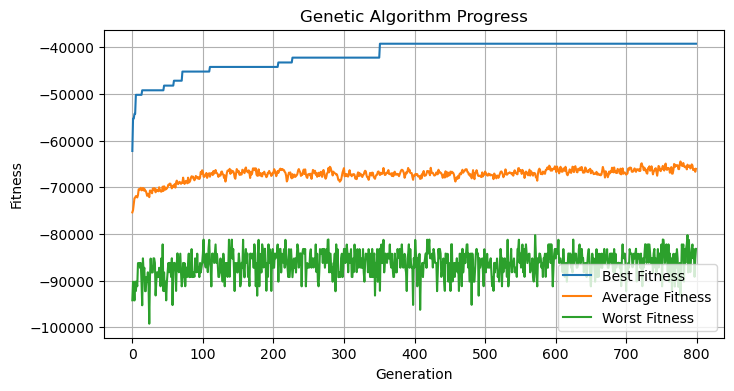

In [16]:
if __name__ == "__main__":
    records = parse_report(DATA_FILE)
    courses_dict, teachers_set, student_dict = build_datasets(records)

    best_schedule, best_hist, avg_hist, worst_hist = run_ga(courses_dict, student_dict)

    print("\n=== BEST SCHEDULE ===")
    for course, (day, time, room) in best_schedule.items():
        print(f"{course:30s} | {DAYS[day]:10s} | {TIME_SLOTS[time]:10s} | {room}")

    plot_fitness(best_hist, avg_hist, worst_hist)